# Analysing SARS-CoV-2 outbreak in Italy with controlled SIR model

The controlled-SIR model describes how regulatory and societal reactions impact the dynamics of a disease reproduction rate. Recent [paper](https://arxiv.org/abs/2004.00493) presents an analytic solution to the controlled-SIR models described as

\begin{equation}
\begin{split}
\tau \dot{S} & = -g(I,S) S I\\
\tau \dot{I} & = \left(g(I,S)S - 1\right)I\\
\tau \dot{R} & = I
\end{split}
\end{equation}
where we denote with S = S(t) the fraction of susceptible (non-affected) individuals, with I = I(t) the fraction of the population that is currently ill (active cases), and with R = R(t) the fraction of recovered or deceased individuals. At all times the following relation holds $S+R+I=1$. 

Unlike the standard SIR model in the controlled version the dissease reproduction rate g, is a function of 
the active cases $I$ and the total cases $X=1-S = I + R$

\begin{equation}
g = \frac{g_0}{1 + \alpha_X X + \alpha_I I}
\end{equation}

Here we will try to infer the region specific control parameters $\alpha_X, \alpha_I$ from the publicly availible [data](https://github.com/pcm-dpc/COVID-19) provided by the Department of Civil Protection of italian goverment. We are particulary interested in determining potential evolution of the control parameters over the course of the outbrake. 

In [1]:
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

from numpyro.distributions.transforms import AffineTransform, ExpTransform, ComposeTransform

npyro.enable_validation(True)
sns.set(style='white', context='notebook', palette='muted')

In [2]:
# load information about the population in different regions

df_N = pd.read_html('http://en.comuni-italiani.it/regionip.html')
df_N = df_N[-5]

columns = df_N.loc[0].values
df_N = df_N.loc[1:20, 1:2]
df_N.columns = columns[1:-2]
df_N['Region'] = ['Lombardia', 
                  'Lazio', 
                  'Campania', 
                  'Sicilia', 
                  'Veneto',
                  'Emilia-Romagna',
                  'Piemonte',
                  'Puglia',
                  'Toscana',
                  'Calabria',
                  'Sardegna',
                  'Liguria',
                  'Marche',
                  'Abruzzo',
                  'Friuli Venezia Giulia',
                  'Trentino-Alto Adige',
                  'Umbria',
                  'Basilicata',
                  'Molise',
                  "Valle d'Aosta"]

df_N['Population'] = df_N['Population'].values.astype(np.int32)

In [3]:
#########################                  
# Note that the region of Trentino-Alto Adige covers, regions of P.A. Bolzano and P.A. Trento which
# are included in the italy's. Hence we will combine them in one in the table bellow. 
#########################

# Load national data in Italy
df_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

# Load and format region specific data.
df_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-regioni/dpc-covid19-ita-regioni.csv')

df_regional = df_regional.set_index('data')

# Merge data for Trento and Bolzano into Trentino-Alto Adige
loc_bolz = df_regional.denominazione_regione == 'P.A. Bolzano'
loc_tren = df_regional.denominazione_regione == 'P.A. Trento'

df_ta = df_regional.loc[loc_bolz, 'totale_positivi':] + \
        df_regional.loc[loc_tren, 'totale_positivi':]

df_ta['denominazione_regione'] = 'Trentino-Alto Adige'

df_regional = df_regional.append(df_ta).reset_index()
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Bolzano'].index)
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Trento'].index)

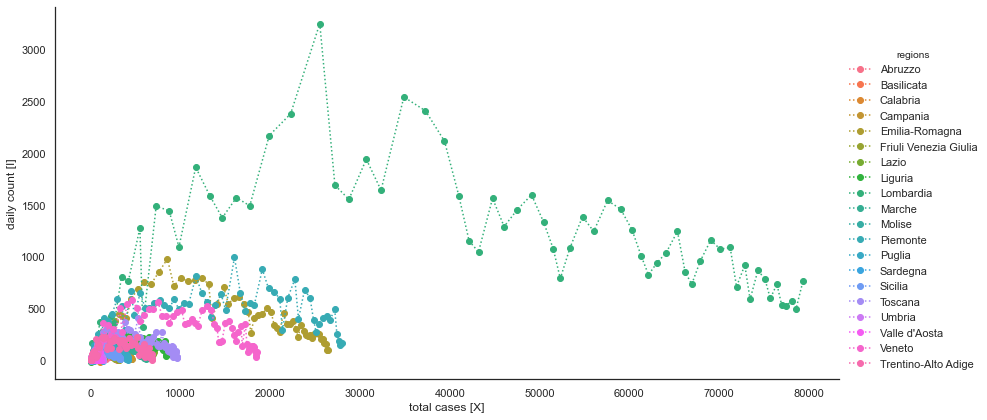

In [4]:
g = sns.FacetGrid(df_regional, hue='denominazione_regione', height=6, aspect=2)
g.map(plt.plot, 'totale_casi', 'nuovi_positivi', marker='o', linestyle=':').add_legend(title='regions');
g.axes[0, 0].set_xlabel('total cases [X]');
g.axes[0, 0].set_ylabel('daily count [I]');

The imported data set contains information about total cases, active cases, recovered cases, daily count and other infrmation. In theory, one would introduce the following mapping total cases -> $X$, active cases -> $I$, recovered cases -> $R$. However, besides the problem that the data provides a large undercounting of the overal numbers (e.g. because of limited testing), active cases and recovered cases are in addition strongly delayed; meaning that if someone recovers (specifically becomes healthy again) this will be reported only after several days, if not weeks. 

A more reliable proxy for the number of active cases are daily cases. If we assume that on a day $t$ the true fraction of active cases is $I(t)$, then if K random tests where pefromed the expected number of daily cases should be proportional to $K \cdot I(t)$. Naturally, one would expect that the majority of people being tested (specially at the early stages of the outbrake) already shows COVID-19 symptomps, the actual number can be strongly biased, in the sense that the number of infected relative to the number of tests could be much larger than $I(t)$.

Additional problem in estimating $I(t)$ lies in the variability of daily tests. Unfortunatly in the current data set the number of daily tests is unknown, except on the last 20 days. Naturally, if we assume fixed $I(t)$ the larger the number of daily tests the larger is the number of daily cases. Hence, an increase in the number of daily cases does not necessarly reflect an increase in an unknown $I(t)$, but rather the proportionality of daily cases to the number of performed tests.

To remeady this issue one can use the following observation. In any outbrake certain percentage of the infected population will succumb to the disease and die. This means that out of total number of cases a certain percentage (hopefully very small) will reflect fatality rate. Furthermore, although thats can be quite delayed we would expect that on average this delay would be constant. Hence, the information about daily deaths and the total number of deaths from COVID-19 (which we assume is more accurate then total number of infected) should reflect, up to a constant factor, the the reports of total and daily cases.

To test this we will compare the daily cases / total cases plot with daily deaths / total deaths plot, where the number of deaths is multiplied by a constant factor during throughout the outbrake.

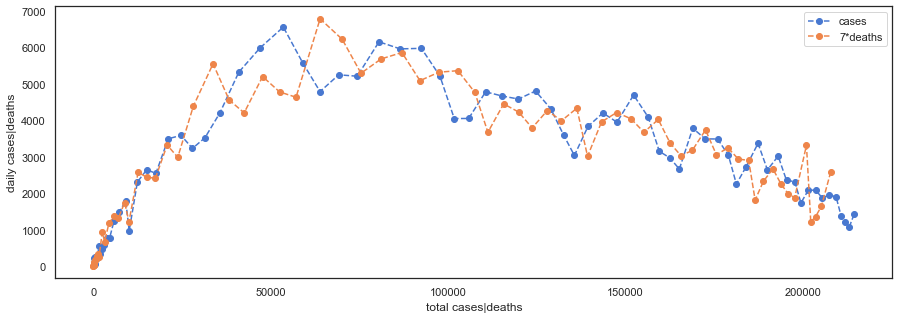

In [5]:
plt.subplots(figsize=(15, 5))
plt.plot(df_national['totale_casi'], df_national['nuovi_positivi'], 'o--', label='cases')
deaths = df_national['deceduti'].iloc[1:]
daily_deaths = df_national['deceduti'].diff().iloc[1:]
plt.plot(deaths * 7, daily_deaths * 7, 'o--', label='7*deaths')

plt.ylabel('daily cases|deaths');
plt.xlabel('total cases|deaths');
plt.legend();

From the graph above, we can conclude that (at least for Italy) althout reports of daily cases and total cases might be biased this bias is constant troughout the outbrake as it follows almos the same trend as the daily deaths - total deaths curve. In other words, if the true total number of cases is $N \cdot X(t)$ (where N stands for the population size) then the observed number of cases will be $X_o(t) = f \cdot N \cdot X(t)$ and observed active cases $I_o(t) = f \cdot N \cdot I(t)$ with proportionality factor $f$ being constant during the outbrake. Furthermore, as we can assume that daily death count from COVID-19 is more accurate than the daily cases we can, use daily deaths as a proxy for reliability of daily reports. In other words, we can estimate the parameters of the controlled-SIR model both based on the daily/total cases data and daily/total deaths data in a hierarhical fashion by poling data from two sources, which should reduce the variability in one of the sources.

Before we continue with the description of the model and the relevant X-I relations, we will format the data appropriatly and extract the relevant columns from the overal data set. We will use the following mapping from italian titles to english 

- data -> date
- totale_case -> X
- nuovi_poitivi -> I
- deceduti -> D
- casi_testati -> total tests
- denominazione_regione -> region

In [7]:
df_national.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                      inplace=True)

df_national['dD'] = df_national['D'].diff()
df_national['dD'].iloc[0] = df_national['D'].iloc[0]

df_regional.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests', 
                            'denominazione_regione': 'region',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                     inplace=True)


/run/media/dimitrije/data/anaconda/envs/jax/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Integrating the contolled SIR model with fixed control parameters
\begin{equation}
\begin{split}
\tau \dot{S} & = -g(I,S) S I\\
\tau \dot{I} & = \left(g(I,S)S - 1\right)I\\
\tau \dot{R} & = I \\
g &= \frac{g_0}{1 + \alpha_X X + \alpha_I I}
\end{split}
\end{equation}
results in the following solution 

$$ I = \frac{g_0 + \alpha_X}{g_0 - \alpha_I} X + \left(\frac{g_0 + \alpha_X}{g_0 - \alpha_I} + \frac{1 + \alpha_X}{\alpha_I} \right) \left[ (1 - X)^{\alpha_I/g_0} - 1\right] $$

In the limit $\alpha_I \rightarrow 0$, that is, the long term control we get the following solution

$$ I = \frac{g_0 + \alpha_X}{g_0} X + \left(\frac{1 + \alpha_X}{g_0}\right) \ln (1-X).$$

In the limit $\alpha_X \rightarrow 0$, that is, the shorth term control we get 

$$ I = \frac{g_0}{g_0 - \alpha_I} X + \left(\frac{g_0}{g_0 - \alpha_I} + \frac{1}{\alpha_I} \right) \left[ (1 - X)^{\alpha_I/g_0} - 1\right] $$

Finally, for $\alpha_I \rightarrow g_0$, we recover 

$$ I = -\frac{1 + \alpha_X}{\alpha_I} X$$

Simlarly, the derivative of $I$ with respect to $X$ becomes

$$ \frac{dI}{dX} = \frac{g_0 + \alpha_X}{g_0 - \alpha_I} - \left(\frac{\alpha_I(g_0 + \alpha_X)}{g_0(g_0 - \alpha_I)} + \frac{1 + \alpha_X}{g_0} \right) (1 - X)^{\alpha_I/g_0 - 1}$$

At initial stages of the outbrake when very small fraction of the population is infected hence, $X \approx 0$
we can express the above derivative as

$$ \frac{dI}{dX} \approx \frac{g_0 - 1}{g_0}$$

Hence, we can constrain $g_0$ value using the observed changes in I_o(t), and X_o(t) where 

$$\Delta I_o \sim \mathcal{N}\left(a \Delta X_o + b, \sigma\right), \qquad g_0 \sim \mathcal{N}\left(\frac{1}{1-a}, \rho\right)$$

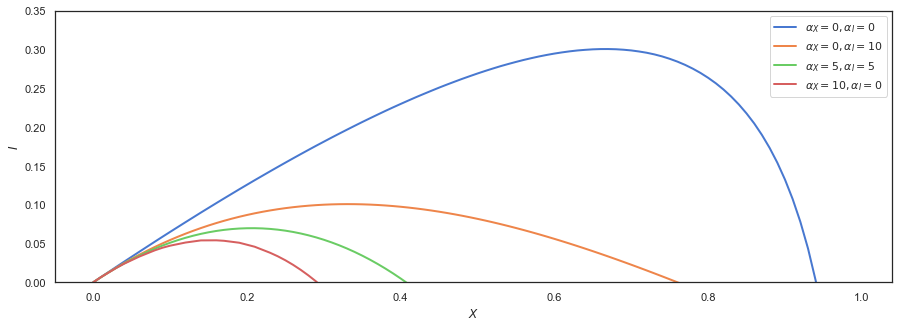

In [8]:
def fun_I(x, aX, aI, g0):
    par1 = (g0 + aX)/(g0 - aI)
    par2 = (1 + aX)/aI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * aI/g0) - 1)

args0 = (0, 1e-3, 3)
args1 = (0, 10, 3)
args2 = (5, 5, 3)
args3 = (10, 1e-3, 3)

X = np.arange(1e-6, 1., .01)

plt.subplots(figsize=(15, 5))

plt.plot(X, fun_I(X, *args0), lw=2, label=r'$\alpha_X=0, \alpha_I=0$')
plt.plot(X, fun_I(X, *args1), lw=2, label=r'$\alpha_X=0, \alpha_I=10$')
plt.plot(X, fun_I(X, *args2), lw=2, label=r'$\alpha_X=5, \alpha_I=5$')
plt.plot(X, fun_I(X, *args3), lw=2, label=r'$\alpha_X=10, \alpha_I=0$')

plt.ylim([0, .35]);
plt.legend();
plt.xlabel(r'$X$');
plt.ylabel(r'$I$');

Besides the $IX$ relation ploted above we will also consider the dynamic case in which we smoothly transtion between the long and short term control regime. For that we will consider the following form of the infection rate 

$$g = \frac{g_0}{1 + \alpha_X \cdot a(t) \cdot X + (1-a(t)) \cdot \alpha_I \cdot I} $$

where 

$$ a(t) = \frac{1}{1 + e^{- \kappa \cdot ( t - \beta)}}$$

In [9]:
def dz_dt(z, t, theta):
    """
    Controleld SIR equations for the case of dynamic control parameters.
    """
    X, I, R = z
    tau = theta['tau']
    alpha_X = theta['a_X']
    alpha_I = theta['a_I']
    g0 = theta['g0']
    a = nn.sigmoid(theta['k'] * (t - theta['b']))

    g = g0/(1 + alpha_X * a * X + (1-a) * alpha_I * I)
    dX_dt = g * (1 - X) * I/tau 
    dI_dt = (g * (1 - X) - 1) * I/tau
    dR_dt = I/tau
    return np.stack([dX_dt, dI_dt, dR_dt])

We will integrate the dynamic model, for comparison with the analytic solution, using an adaptive Runge-Kutta ODE integrator availible in the jax library.

In [10]:
T = 50
ts = np.arange(0, float(T), 1/5.)
z_init = np.array([1e-6, 1e-6, 0.])
theta = {'tau': 2. * np.ones(1),
         'a_X': 0. * np.ones(1),
         'a_I': 0. * np.ones(1),
         'g0': 3. * np.ones(1),
         'k': 0. * np.ones(1),
         'b': 0. * np.ones(1)}

z0_0 = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

theta['a_I'] = 20. * np.ones(1)
z0_10 = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

theta['a_X'] = 10. * np.ones(1)
theta['a_I'] = 10. * np.ones(1)
z5_5 = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

theta['a_X'] = 20. * np.ones(1)
theta['a_I'] = 0. * np.ones(1)
z10_0 = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

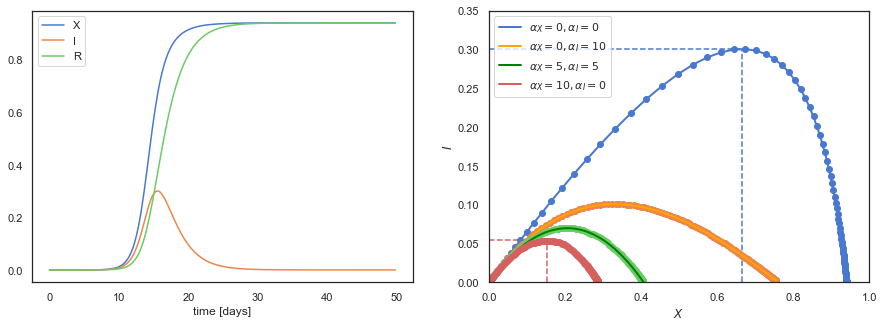

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(ts, z0_0)
axes[0].set_xlabel('time [days]');
axes[0].legend(labels=['X', 'I', 'R']);

# X peak = (g_0 - 1)/ (g_0 + alpha)
X_peak = 2/3
# I_peak = (g_0 - 1)/g_0 + (1 + alpha)/g_0 * [ln(1 + alpha) - ln(g_0 + alpha)]
I_peak = (3 - 1)/3 + 1/3 * (- np.log(3))

axes[1].plot(z0_0[:, 0], z0_0[:, 1], 'o');
plt.plot(z0_0[:, 0], fun_I(z0_0[:, 0], *args0), 'b', lw=2, label=r'$\alpha_X=0, \alpha_I=0$')
axes[1].vlines(X_peak, 0, I_peak, 'b', linestyle='--')
axes[1].hlines(I_peak, 0, X_peak, 'b', linestyle='--')

axes[1].plot(z0_10[:, 0], z0_10[:, 1], 'o');
plt.plot(z0_10[:, 0], fun_I(z0_10[:, 0], *args1), 'orange', lw=2, label=r'$\alpha_X=0, \alpha_I=10$')

axes[1].plot(z5_5[:, 0], z5_5[:, 1], 'o');
plt.plot(z5_5[:, 0], fun_I(z5_5[:, 0], *args2), 'green', lw=2, label=r'$\alpha_X=5, \alpha_I=5$')

X_peak = (3 - 1)/(3 + 10)
I_peak = (3 - 1)/3 + (1 + 10)/3 * (np.log(1 + 10) - np.log(3 + 10))

axes[1].plot(z10_0[:, 0], z10_0[:, 1], 'o');
plt.plot(z10_0[:, 0], fun_I(z10_0[:, 0], *args3), 'r', lw=2, label=r'$\alpha_X=10, \alpha_I=0$')
axes[1].vlines(X_peak, 0, I_peak, 'r', linestyle='--')
axes[1].hlines(I_peak, 0, X_peak, 'r', linestyle='--')

axes[1].legend();
axes[1].set_xlim([0., 1.]);
axes[1].set_ylim([0., .35]);
axes[1].set_xlabel(r'$X$');
axes[1].set_ylabel(r'$I$');

In [12]:
def static(N, data, obs=None, K=1):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    f = npyro.sample('f', dist.HalfCauchy(.1))
    total_count = f * float(N)/10.
    
    X_data = data['X']
    I_data = data['I']
    
#     dX_data = np.diff(X_data, axis=-1)[5:15].cumsum()
#     dI_data = np.diff(I_data, axis=-1)[5:15].cumsum()
    
#     a = npyro.sample('a', dist.Beta(1., 1.))
#     b = npyro.sample('b', dist.Cauchy(0., 5.))
#     scale = npyro.sample('scale', dist.HalfCauchy(1.))
    
#     m = a * dX_data + b
#     npyro.sample('slope', dist.Gamma(scale * m, scale), obs=dI_data)
#     m_g0 = 1/(1 - a)
    
    a_X = npyro.sample('a_X', dist.InverseGamma(2., 2.))
    a_I = npyro.sample('a_I', dist.InverseGamma(2., 2.))
    
    g0 = npyro.sample('g0', dist.Gamma(2., 2.))
    
    I_pred = total_count * fun_I(X_data/total_count, a_X, a_I, g0)
    
    I_pred = npyro.deterministic('I', np.where(I_pred > 0, I_pred, 1.))
        
    # measurement errors
    scale_I = npyro.sample("scale_I", dist.HalfCauchy(1.))
    
    with npyro.plate('obs', X_data.shape[0]):
        o_i = dist.Normal(0., 1.)
        o_i_1 = dist.TransformedDistribution(o_i, AffineTransform(np.log(I_pred), scale_I))
        npyro.sample("I_o", dist.TransformedDistribution(o_i_1, ExpTransform()), obs=obs)
    
def dynamic(T, N, data, obs=[None, None], K=1):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, R, D
    :param numpy.ndarray obs: 
    :param int K: number of categories/regions
    """
    
    # infer the fraction of the total population that can be infected. With this we assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    
    # initial conditions
    m_init = np.array([1e-3, 1e-5])
    z_init = npyro.sample("z_init", dist.Beta(1e5 * m_init, 1e5 * (1 - m_init)))
    z_init = np.concatenate([z_init.sum(-1, keepdims=True), z_init], -1)
    
    # population fraction
    f = npyro.sample('f', dist.Beta(1., 9.))
        
    # measurement times
    ts = np.arange(float(T))
    # parameters of dz_dt
    tau = npyro.sample('tau', dist.InverseGamma(3., 6.))
    a_X = npyro.sample('a_X', dist.InverseGamma(2., 2.))
    a_I = npyro.sample('a_I', dist.InverseGamma(2., 2.))
    g0 = npyro.sample('g0', dist.InverseGamma(3., 4.))
    k = npyro.sample('k', dist.Normal(0., 1.))
    b = npyro.sample('b', dist.Cauchy(float(T)/2, 1.))
    theta = {'tau': tau,
             'a_X': a_X,
             'a_I': a_I,
             'g0': g0, 
             'k': k,
             'b': b}
    
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)
    X = npyro.deterministic('X', z[..., 0])
    I = npyro.deterministic('I', z[..., 1])

    # measurement errors
    nu_X = npyro.sample("nu_X", dist.Gamma(40., 2.))
    nu_I = npyro.sample("nu_I", dist.Gamma(200., 2.))

    # measured total infected
    total_count = f * float(N)

    scale = 1. / np.sqrt(nu_X)
    npyro.sample("X_o", dist.LogNormal(np.log(total_count * X), scale), obs=obs[0])
    
    scale = 1. / np.sqrt(nu_I)
    npyro.sample("I_o", dist.LogNormal(np.log(total_count * I), scale), obs=obs[1])

    
data = {'I': np.array(df_national['I'].values),
        'X': np.array(df_national['X'].values)}

N = df_N['Population'].sum()
T = len(df_national)
    
with npyro.handlers.seed(rng_seed=1):
    dynamic(T, N, data)
    static(N, data)

In [13]:
num_warmup = 1000
num_samples = 1000
obs = data['I']

nuts = NUTS(static, dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples)
mcmc.run(random.PRNGKey(24413323), N=N, data=data, obs=obs)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:15<00:00, 133.02it/s, 31 steps of size 2.34e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     64.25     15.91     61.36     40.73     90.51    106.61      1.01
       a_X      0.92      0.53      0.77      0.24      1.71     67.10      1.02
         f      0.27      0.07      0.25      0.19      0.37     65.42      1.02
        g0      1.31      0.03      1.31      1.27      1.36    389.32      1.00
   scale_I      0.26      0.02      0.26      0.23      0.30    632.39      1.01

Number of divergences: 26


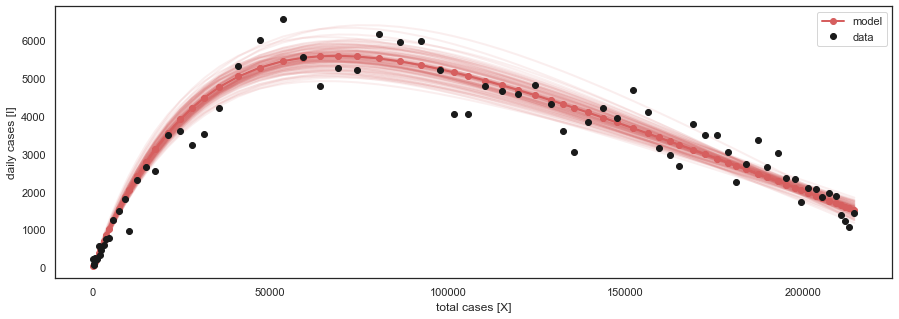

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

axes.plot(data['X'], samples['I'].mean(0), 'ro-', label='model', lw=2)
axes.plot(data['X'], samples['I'][::10].T, 'r', lw=2, alpha=.1)

axes.plot(data['X'], data['I'], 'ko', label='data')

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend();

In [15]:
samples = {}
datas = {}
for region in df_N.Region:
    df = df_regional[['I', 'X']].loc[df_regional.region == region]
    df = df.loc[(df > 0).any(1)]
    df = df.where(df > 0, 1.)
    data = {'I': np.array(df['I'].values),
            'X': np.array(df['X'].values)}

    obs = data['I']
    datas[region] = [data['X'], data['I']]
    N = df_N['Population'].loc[df_N.Region == region].values[0]

    nuts = NUTS(static, dense_mass=True)
    mcmc = MCMC(nuts, num_warmup, num_samples)
    mcmc.run(random.PRNGKey(2483265),N=N, data=data, obs=obs)
    print(region)
    mcmc.print_summary()
    samples[region] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:09<00:00, 213.85it/s, 15 steps of size 2.57e-01. acc. prob=0.92]


Lombardia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     77.87     23.46     72.68     46.02    112.55    244.73      1.00
       a_X      0.88      0.55      0.73      0.23      1.60    131.98      1.00
         f      0.66      0.18      0.62      0.42      0.91    147.00      1.00
        g0      1.30      0.04      1.30      1.24      1.36    818.49      1.00
   scale_I      0.35      0.03      0.35      0.31      0.40    736.57      1.00

Number of divergences: 5


sample: 100%|██████████| 2000/2000 [00:17<00:00, 116.48it/s, 1023 steps of size 3.32e-06. acc. prob=0.99]


Lazio

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      0.97      0.00      0.97      0.97      0.97      3.94      1.57
       a_X      1.93      0.00      1.93      1.93      1.93      4.08      1.14
         f      0.38      0.00      0.38      0.38      0.38      2.85      2.18
        g0      1.06      0.00      1.06      1.06      1.06      5.13      1.00
   scale_I      2.24      0.00      2.24      2.24      2.24      2.50      2.71

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:17<00:00, 112.93it/s, 1023 steps of size 9.69e-05. acc. prob=0.78]


Campania

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      1.28      0.00      1.28      1.28      1.28      4.63      1.47
       a_X      2.40      0.00      2.39      2.39      2.40      5.11      1.21
         f      0.69      0.00      0.69      0.68      0.69      2.52      2.55
        g0      1.03      0.00      1.03      1.03      1.03     13.27      1.28
   scale_I      1.48      0.01      1.48      1.48      1.49      2.44      2.83

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:09<00:00, 205.92it/s, 15 steps of size 2.22e-01. acc. prob=0.76]


Sicilia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     48.72     21.24     42.90     18.59     74.77     41.91      1.04
       a_X      1.26      0.98      0.92      0.17      3.01     19.02      1.08
         f      0.05      0.02      0.05      0.03      0.09     26.61      1.06
        g0      1.28      0.04      1.28      1.21      1.34    246.62      1.00
   scale_I      0.51      0.05      0.51      0.44      0.59    230.83      1.00

Number of divergences: 109


sample: 100%|██████████| 2000/2000 [00:17<00:00, 115.29it/s, 1023 steps of size 6.53e-06. acc. prob=0.77]


Veneto

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      1.15      0.00      1.15      1.15      1.15      8.33      1.02
       a_X      2.26      0.00      2.26      2.26      2.26      8.72      1.38
         f      0.48      0.00      0.48      0.48      0.48      3.18      2.01
        g0      1.14      0.00      1.14      1.14      1.14      7.93      1.03
   scale_I      0.54      0.00      0.54      0.54      0.54      2.66      2.51

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:09<00:00, 211.31it/s, 15 steps of size 1.81e-01. acc. prob=0.92]


Emilia-Romagna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     57.82     18.49     53.45     33.82     82.07     57.27      1.01
       a_X      0.90      0.58      0.73      0.25      1.52     50.01      1.01
         f      0.41      0.11      0.39      0.28      0.53     52.94      1.01
        g0      1.33      0.04      1.33      1.27      1.39    636.96      1.00
   scale_I      0.33      0.03      0.32      0.28      0.37    449.43      1.00

Number of divergences: 9


sample: 100%|██████████| 2000/2000 [00:09<00:00, 215.93it/s, 15 steps of size 1.53e-01. acc. prob=0.75]


Piemonte

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     47.80     41.09     39.75      1.91     97.64     60.59      1.01
       a_X      0.81      0.46      0.68      0.25      1.46    316.00      1.02
         f      0.58      0.20      0.54      0.34      0.83    161.59      1.02
        g0      1.22      0.06      1.22      1.13      1.30     43.06      1.01
   scale_I      0.77      0.07      0.77      0.66      0.88     34.03      1.03

Number of divergences: 80


sample: 100%|██████████| 2000/2000 [00:09<00:00, 201.87it/s, 15 steps of size 1.57e-01. acc. prob=0.72] 


Puglia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     48.57     26.97     42.65     15.22     79.32     83.52      1.00
       a_X      1.20      0.90      0.96      0.20      2.13     97.54      1.00
         f      0.08      0.03      0.07      0.04      0.11     94.09      1.00
        g0      1.32      0.07      1.31      1.21      1.43    127.45      1.00
   scale_I      0.66      0.06      0.66      0.57      0.75    229.10      1.00

Number of divergences: 87


sample: 100%|██████████| 2000/2000 [00:16<00:00, 123.78it/s, 1023 steps of size 3.36e-05. acc. prob=0.92]


Toscana

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      1.33      0.00      1.33      1.33      1.33      2.62      2.45
       a_X      1.47      0.00      1.47      1.47      1.47      6.19      1.00
         f      0.21      0.00      0.21      0.21      0.21      3.66      1.57
        g0      1.18      0.00      1.18      1.17      1.18      5.19      1.11
   scale_I      0.57      0.00      0.57      0.57      0.58      2.93      2.10

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:17<00:00, 112.50it/s, 1023 steps of size 2.09e-05. acc. prob=0.84]


Calabria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      1.28      0.00      1.28      1.28      1.28      5.01      1.06
       a_X      5.90      0.00      5.90      5.89      5.90      5.81      1.13
         f      0.09      0.00      0.09      0.09      0.09     13.81      1.09
        g0      1.22      0.00      1.22      1.22      1.22      5.29      1.01
   scale_I      0.87      0.00      0.87      0.87      0.87      2.57      2.74

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:09<00:00, 205.70it/s, 63 steps of size 4.61e-02. acc. prob=0.82] 


Sardegna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     28.48     12.95     27.07      6.33     45.91     80.09      1.00
       a_X      1.14      0.66      0.97      0.30      2.13    104.01      1.00
         f      0.05      0.02      0.05      0.03      0.08     89.53      1.00
        g0      1.31      0.10      1.30      1.19      1.44     78.92      1.00
   scale_I      0.78      0.09      0.77      0.64      0.91     92.37      1.01

Number of divergences: 80


sample: 100%|██████████| 2000/2000 [00:10<00:00, 197.81it/s, 15 steps of size 2.95e-01. acc. prob=0.91]


Liguria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     82.78     37.42     75.45     31.47    135.22    356.22      1.00
       a_X      0.86      0.49      0.74      0.22      1.46    441.61      1.00
         f      0.55      0.16      0.51      0.35      0.83    440.37      1.00
        g0      1.26      0.04      1.26      1.19      1.33    415.85      1.00
   scale_I      0.58      0.05      0.57      0.50      0.66    479.83      1.01

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [00:09<00:00, 203.19it/s, 31 steps of size 1.14e-01. acc. prob=0.93] 


Marche

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     57.84     13.50     55.36     39.24     79.19    452.06      1.00
       a_X      0.88      0.49      0.76      0.21      1.58    305.88      1.00
         f      0.18      0.04      0.17      0.12      0.24    332.33      1.00
        g0      1.58      0.09      1.57      1.43      1.73    488.09      1.00
   scale_I      0.35      0.03      0.34      0.30      0.39    614.28      1.00

Number of divergences: 5


sample: 100%|██████████| 2000/2000 [00:18<00:00, 110.06it/s, 1023 steps of size 1.45e-04. acc. prob=0.80]


Abruzzo

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      1.53      0.01      1.53      1.52      1.54      3.92      1.54
       a_X      1.67      0.02      1.67      1.64      1.70      3.26      1.73
         f      0.72      0.00      0.72      0.72      0.73      9.88      1.21
        g0      1.06      0.00      1.06      1.05      1.06      7.66      1.05
   scale_I      1.16      0.01      1.16      1.14      1.17      2.50      3.43

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:09<00:00, 214.11it/s, 31 steps of size 7.16e-02. acc. prob=0.98]


Friuli Venezia Giulia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     41.39     14.32     39.13     20.07     61.88    389.72      1.00
       a_X      0.88      0.51      0.75      0.24      1.54    194.35      1.00
         f      0.16      0.04      0.15      0.10      0.21    197.02      1.00
        g0      1.32      0.07      1.32      1.22      1.43    477.85      1.00
   scale_I      0.56      0.05      0.56      0.48      0.65    584.07      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:16<00:00, 121.51it/s, 1023 steps of size 8.22e-04. acc. prob=0.78]


Trentino-Alto Adige

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      2.05      0.11      2.04      1.89      2.20     21.60      1.13
       a_X      0.99      0.29      0.97      0.54      1.41      2.59      2.34
         f      0.34      0.04      0.36      0.27      0.39      2.71      2.14
        g0      1.21      0.01      1.21      1.20      1.23      6.08      1.01
   scale_I      1.50      0.12      1.50      1.33      1.69     11.73      1.00

Number of divergences: 61


sample: 100%|██████████| 2000/2000 [00:16<00:00, 120.60it/s, 1023 steps of size 7.01e-05. acc. prob=0.87]


Umbria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      2.03      0.00      2.03      2.02      2.03      4.33      1.72
       a_X      2.24      0.00      2.24      2.23      2.25      4.16      1.20
         f      0.31      0.00      0.31      0.31      0.31      2.95      1.95
        g0      1.08      0.00      1.08      1.08      1.09      7.37      1.00
   scale_I      3.50      0.01      3.49      3.49      3.51      2.54      2.99

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:13<00:00, 152.29it/s, 510 steps of size 4.91e-03. acc. prob=0.75] 


Basilicata

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      2.47      4.39      1.30      0.22      4.68     76.72      1.01
       a_X      3.48      2.56      2.85      0.35      7.21      9.11      1.22
         f      0.05      0.03      0.04      0.02      0.08      8.15      1.23
        g0      1.30      0.06      1.29      1.21      1.38     67.99      1.00
   scale_I      0.95      0.09      0.95      0.81      1.11     64.72      1.02

Number of divergences: 390


sample: 100%|██████████| 2000/2000 [00:14<00:00, 140.91it/s, 1023 steps of size 4.78e-05. acc. prob=0.74]


Molise

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I      0.58      0.06      0.56      0.50      0.69      5.74      1.24
       a_X      1.40      0.15      1.44      1.18      1.65      2.99      1.91
         f      0.10      0.01      0.10      0.09      0.11      2.87      2.06
        g0      1.13      0.00      1.13      1.12      1.13      8.16      1.02
   scale_I      1.00      0.01      1.00      0.98      1.02      2.96      2.15

Number of divergences: 147


sample: 100%|██████████| 2000/2000 [00:10<00:00, 192.75it/s, 63 steps of size 2.90e-02. acc. prob=0.92] 


Valle d'Aosta

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I     55.52     26.86     50.32     15.83     88.61    236.80      1.00
       a_X      0.86      0.47      0.74      0.25      1.52    357.83      1.00
         f      0.53      0.18      0.49      0.28      0.83    145.27      1.00
        g0      1.41      0.21      1.35      1.16      1.70    108.88      1.01
   scale_I      1.08      0.10      1.07      0.93      1.25    449.63      1.01

Number of divergences: 35


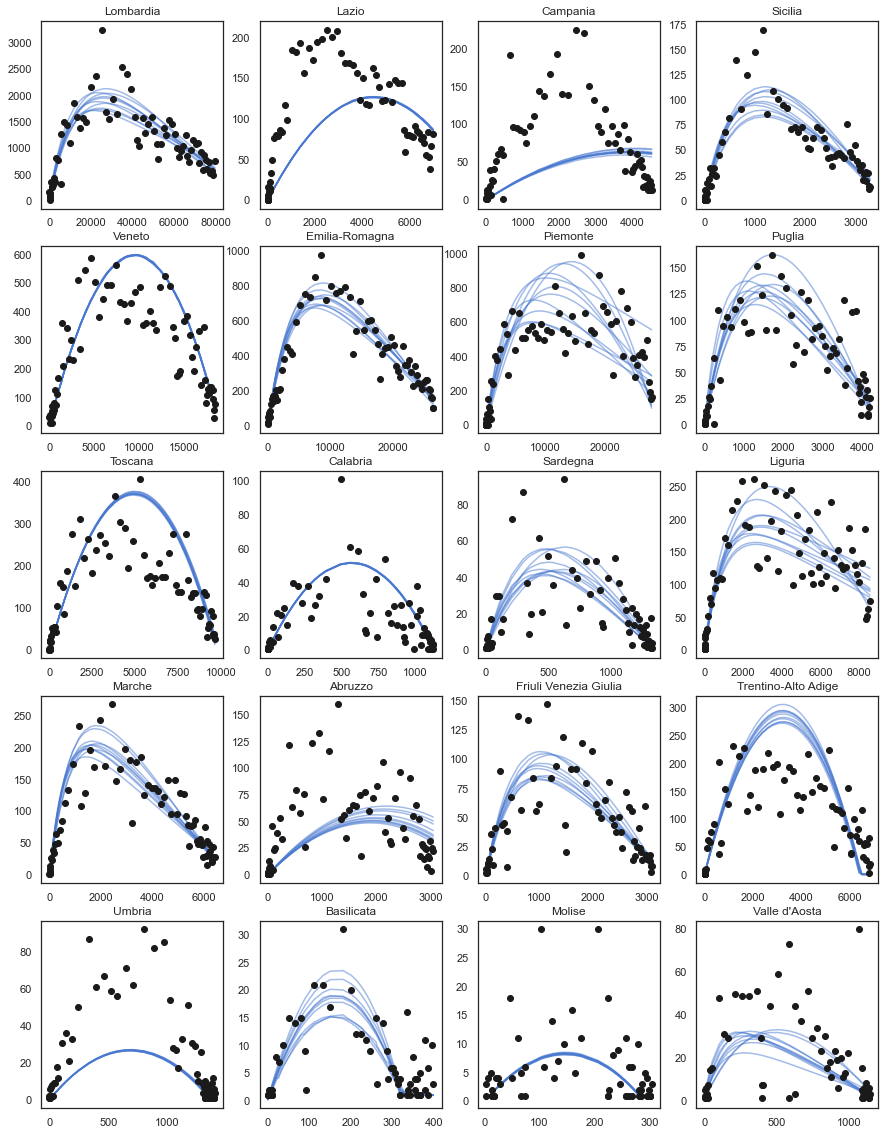

In [16]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

ax = axes.flatten()
for i, key in enumerate(samples):
    X = datas[key][0]
    I = datas[key][1]
    for j in range(num_samples):
        if j % 100 == 0:
            ax[i].plot(X, samples[key]['I'][j], 'b', alpha=.5);
    
    ax[i].plot(X, I, 'ko', lw=2);
    ax[i].set_title(key)

In the figure above, black dots denote the data andblue lines posterior samples of estimated I.

In [18]:
table = {r'$\alpha_X$': [],
         r'$\alpha_I$': [],
         r'$g_0$': [],
         r'$\tau_2$': [],
         'CEI': [],}
for key in samples:
    a_x = samples[key]['a_X']
    pa_x = np.percentile(a_x, [5., 50., 95.])
    
    a_i = samples[key]['a_I']
    pa_i = np.percentile(a_i, [5., 50., 95.])
    
    table[r'$\alpha_X$'].append("{:.1f} [{:.1f}, {:.1f}]".format(pa_x[1], pa_x[0], pa_x[-1]))
    table[r'$\alpha_I$'].append("{:.1f} [{:.1f}, {:.1f}]".format(pa_i[1], pa_i[0], pa_i[-1]))
    
    g0 = samples[key]['g0']
    pg0 = np.percentile(g0, [5., 50., 95.])
    table[r'$g_0$'].append("{:.2f} [{:.2f}, {:.2f}]".format(pg0[1], pg0[0], pg0[-1]))

    cei = a_x/(a_x + samples[key]['g0'])
    pcei = np.percentile(cei, [5., 50., 95.])
    table['CEI'].append("{:.2f} [{:.2f}, {:.2f}]".format(pcei[1], pcei[0], pcei[-1]))
    
    tau2 = np.log(2.)/np.log(samples[key]['g0'])
    pt2 = np.percentile(tau2, [5., 50., 95.])
    
    table[r'$\tau_2$'].append("{:.1f} [{:.1f}, {:.1f}]".format(pt2[1], pt2[0], pt2[-1]))

df_tbl = pd.DataFrame(table)
df_tbl['region'] = df_N.Region.values
df_tbl.set_index('region', inplace=True)
df_tbl

,$\alpha_X$,$\alpha_I$,$g_0$,$\tau_2$,CEI
region,,,,,
Lombardia,"0.7 [0.3, 2.1]","72.7 [49.7, 121.7]","1.30 [1.25, 1.37]","2.7 [2.2, 3.1]","0.36 [0.20, 0.61]"
Lazio,"1.9 [1.9, 1.9]","1.0 [1.0, 1.0]","1.06 [1.06, 1.06]","11.9 [11.9, 11.9]","0.65 [0.65, 0.65]"
Campania,"2.4 [2.4, 2.4]","1.3 [1.3, 1.3]","1.03 [1.03, 1.03]","20.9 [20.3, 21.9]","0.70 [0.70, 0.70]"
Sicilia,"0.9 [0.3, 3.7]","42.9 [25.0, 88.0]","1.28 [1.23, 1.35]","2.8 [2.3, 3.4]","0.42 [0.21, 0.74]"
Veneto,"2.3 [2.3, 2.3]","1.2 [1.2, 1.2]","1.14 [1.14, 1.14]","5.2 [5.2, 5.2]","0.66 [0.66, 0.66]"
Emilia-Romagna,"0.7 [0.3, 2.0]","53.5 [37.5, 91.1]","1.33 [1.27, 1.39]","2.5 [2.1, 2.9]","0.36 [0.21, 0.60]"
Piemonte,"0.7 [0.3, 1.7]","39.8 [2.8, 123.3]","1.22 [1.14, 1.33]","3.5 [2.4, 5.3]","0.36 [0.21, 0.58]"
Puglia,"1.0 [0.4, 3.0]","42.7 [19.1, 94.2]","1.31 [1.22, 1.46]","2.5 [1.8, 3.5]","0.42 [0.21, 0.70]"
Toscana,"1.5 [1.5, 1.5]","1.3 [1.3, 1.3]","1.18 [1.17, 1.18]","4.3 [4.3, 4.3]","0.56 [0.56, 0.56]"


NOTE: The fitting of the static control model converged only for Lombardia, Sicilia, Veneto, Emilia-Romagna, Piemonte, Puglia, Sardegna, Liguria, Marche, Friuli Venezia Giulia, and Trentino-Alto Adige. Hence the fits and the tabular values should be ignored for other regions until the convergence issues are fixed.

